In [2]:
import pandas as pd
import numpy as np
import spacy
import re
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from hdbscan import HDBSCAN
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')

nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Combined preprocessing function with fewer regex passes
def custom_preprocessor(text):
    # Removes punctuation, non-alphabet characters, single alphabets, numbers, PGP keys, non-ASCII characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Removes punctuation and non-alphabet characters
    text = re.sub(r'\b[a-zA-Z]\b|\b\d+\b', '', text)  # Removes single alphabets and numbers
    text = re.sub(r'[^\x00-\x7F]+|\b(pgp|begin|end|key|public|block)\b', '', text, flags=re.IGNORECASE)
    words = text.lower().split()
    words = [word for word in words if word not in nltk_stopwords]  # Stopword removal
    return ' '.join(words)


In [6]:
data = pd.read_csv('cleaned_english_posts.csv')

# Efficiently configuring CountVectorizer with custom preprocessor
vectorizer_model = CountVectorizer(preprocessor=custom_preprocessor, stop_words='english')

In [5]:
# Loading the pre-trained FastText model
fasttext_model = KeyedVectors.load_word2vec_format('final_fasttext_model.bin', binary=True)
print("FastText model loaded successfully.")


FastText model loaded successfully.


In [7]:
# Getting the unique years
years = data['year'].unique()

# Initializing lists to store results
topic_diversity_scores = []
iwec_scores_per_year = {}
years_list = []
doc_counts = []

# Initializing variables for weighted averaging
total_docs = 0
weighted_diversity = 0
overall_weighted_iwec = 0


In [10]:
# Optimized loop for each year
for year in tqdm(years, desc="Processing years"):
    # Filter data for the current year
    df_year = data[data['year'] == year]
    docs = df_year['post_content'].tolist()
    
    # Skip years without any documents
    num_docs = len(df_year)
    if num_docs == 0:
        continue
    
    # Run BERTopic with optimized settings
    topic_model = BERTopic(
        vectorizer_model=vectorizer_model, 
        min_topic_size=5,                  # Small topic size for more granularity
        nr_topics=10,                      # Topic reduction
        hdbscan_model=HDBSCAN(min_cluster_size=5, min_samples=3),  # Fine-grained clustering
        verbose=True)                     
    topics, _ = topic_model.fit_transform(docs)
    
    # Assigning topics back to the DataFrame
    df_year['topic'] = topics
    
    # Getting topics and their top words
    topics_info = topic_model.get_topics()
    topic_ids = list(topics_info.keys())
    
    # Computing Topic Diversity
    num_top_words = 30  # Number of top words per topic for diversity calculation
    all_top_words = []
    for topic_id in topic_ids:
        words = [word for word, _ in topics_info[topic_id][:num_top_words]]
        all_top_words.extend(words)
    unique_words = set(all_top_words)
    total_words = len(all_top_words)
    topic_diversity_score = len(unique_words) / total_words if total_words > 0 else 0
    topic_diversity_scores.append(topic_diversity_score)
    
    # Accumulating weighted diversity
    weighted_diversity += topic_diversity_score * num_docs
    total_docs += num_docs
    doc_counts.append(num_docs)
    years_list.append(year)
    
    # IWEC Scores calculation
    num_top_words_iwec = 10  # Number of top words per topic for IWEC calculation
    topic_words_list = []
    for topic_id in topic_ids:
        words = [word for word, _ in topics_info[topic_id][:num_top_words_iwec]]
        topic_words_list.append((topic_id, words))
    
    iwec_scores = []
    for topic_id, words in topic_words_list:
        # Retrieve embeddings for the words
        embeddings = np.array([fasttext_model[word] for word in words if word in fasttext_model])
        if len(embeddings) < 2:
            coherence = 0.0
        else:
            similarities = cosine_similarity(embeddings)
            coherence = np.mean(similarities[np.triu_indices_from(similarities, k=1)])
        iwec_scores.append((topic_id, coherence))
    
    # Getting topic counts
    topic_counts = df_year['topic'].value_counts().reset_index()
    topic_counts.columns = ['topic_id', 'doc_count']
    total_docs_in_year = topic_counts['doc_count'].sum()
    topic_counts['topic_proportion'] = topic_counts['doc_count'] / total_docs_in_year
    
    # Converting iwec_scores to DataFrame
    iwec_scores_df = pd.DataFrame(iwec_scores, columns=['topic_id', 'iwec_score'])
    
    # Merge topic_counts and iwec_scores_df
    topic_df = pd.merge(topic_counts, iwec_scores_df, on='topic_id', how='inner')
    
    # Computing weighted IWEC score
    weighted_iwec_score = np.sum(topic_df['iwec_score'] * topic_df['topic_proportion'])
    iwec_scores_per_year[year] = weighted_iwec_score
    
    # Accumulating overall weighted IWEC score
    overall_weighted_iwec += weighted_iwec_score * num_docs
    
    # Generating word clouds for each topic
    for topic_id in topic_ids:
        words_scores = topics_info[topic_id][:num_top_words]
        word_freq = {word: score for word, score in words_scores}
        if not word_freq:
            continue
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
        # Save word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Year {year}, Topic {topic_id}")
        plt.savefig(f"bertopic_wordcloud_year_{year}_topic_{topic_id}.png")
        plt.close()
    
    # Printing results for each year
    print(f"Year {year}: Topic Diversity Score = {topic_diversity_score:.4f}, IWEC Score = {weighted_iwec_score:.4f}")

Processing years:   0%|          | 0/7 [00:00<?, ?it/s]2024-09-23 04:06:30,166 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/305 [00:00<?, ?it/s]

2024-09-23 04:12:13,111 - BERTopic - Embedding - Completed ✓
2024-09-23 04:12:13,112 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-23 04:12:39,004 - BERTopic - Dimensionality - Completed ✓
2024-09-23 04:12:39,012 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-23 04:12:39,285 - BERTopic - Cluster - Completed ✓
2024-09-23 04:12:39,286 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-23 04:12:40,862 - BERTopic - Representation - Completed ✓
2024-09-23 04:12:40,864 - BERTopic - Topic reduction - Reducing number of topics
2024-09-23 04:12:42,098 - BERTopic - Topic reduction - Reduced number of topics from 541 to 10
Processing years:  14%|█▍        | 1/7 [06:14<37:28, 374.78s/it]2024-09-23 04:12:44,950 - BERTopic - Embedding - Transforming documents to embeddings.


Year 2024: Topic Diversity Score = 0.8500, IWEC Score = 0.3466


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

2024-09-23 04:13:24,904 - BERTopic - Embedding - Completed ✓
2024-09-23 04:13:24,905 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-23 04:13:32,726 - BERTopic - Dimensionality - Completed ✓
2024-09-23 04:13:32,727 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-23 04:13:32,753 - BERTopic - Cluster - Completed ✓
2024-09-23 04:13:32,754 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-23 04:13:32,975 - BERTopic - Representation - Completed ✓
2024-09-23 04:13:32,976 - BERTopic - Topic reduction - Reducing number of topics
2024-09-23 04:13:33,197 - BERTopic - Topic reduction - Reduced number of topics from 75 to 10
Processing years:  29%|██▊       | 2/7 [07:05<15:21, 184.36s/it]2024-09-23 04:13:36,030 - BERTopic - Embedding - Transforming documents to embeddings.


Year 2021: Topic Diversity Score = 0.8500, IWEC Score = 0.3845


Batches:   0%|          | 0/138 [00:00<?, ?it/s]

2024-09-23 04:15:31,374 - BERTopic - Embedding - Completed ✓
2024-09-23 04:15:31,375 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-23 04:15:35,131 - BERTopic - Dimensionality - Completed ✓
2024-09-23 04:15:35,133 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-23 04:15:35,238 - BERTopic - Cluster - Completed ✓
2024-09-23 04:15:35,239 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-23 04:15:35,825 - BERTopic - Representation - Completed ✓
2024-09-23 04:15:35,826 - BERTopic - Topic reduction - Reducing number of topics
2024-09-23 04:15:36,336 - BERTopic - Topic reduction - Reduced number of topics from 237 to 10
Processing years:  43%|████▎     | 3/7 [09:08<10:25, 156.28s/it]2024-09-23 04:15:38,897 - BERTopic - Embedding - Transforming documents to embeddings.


Year 2023: Topic Diversity Score = 0.9000, IWEC Score = 0.3814


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-23 04:16:35,424 - BERTopic - Embedding - Completed ✓
2024-09-23 04:16:35,425 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-23 04:16:42,832 - BERTopic - Dimensionality - Completed ✓
2024-09-23 04:16:42,833 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-23 04:16:42,901 - BERTopic - Cluster - Completed ✓
2024-09-23 04:16:42,902 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-23 04:16:43,296 - BERTopic - Representation - Completed ✓
2024-09-23 04:16:43,297 - BERTopic - Topic reduction - Reducing number of topics
2024-09-23 04:16:43,686 - BERTopic - Topic reduction - Reduced number of topics from 156 to 10
Processing years:  57%|█████▋    | 4/7 [10:16<06:03, 121.22s/it]2024-09-23 04:16:46,358 - BERTopic - Embedding - Transforming documents to embeddings.


Year 2022: Topic Diversity Score = 0.7700, IWEC Score = 0.3988


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

2024-09-23 04:17:06,189 - BERTopic - Embedding - Completed ✓
2024-09-23 04:17:06,189 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-23 04:17:08,536 - BERTopic - Dimensionality - Completed ✓
2024-09-23 04:17:08,537 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-23 04:17:08,557 - BERTopic - Cluster - Completed ✓
2024-09-23 04:17:08,558 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-23 04:17:08,689 - BERTopic - Representation - Completed ✓
2024-09-23 04:17:08,690 - BERTopic - Topic reduction - Reducing number of topics
2024-09-23 04:17:08,824 - BERTopic - Topic reduction - Reduced number of topics from 47 to 10
Processing years:  71%|███████▏  | 5/7 [10:41<02:53, 86.81s/it] 2024-09-23 04:17:12,168 - BERTopic - Embedding - Transforming documents to embeddings.


Year 2020: Topic Diversity Score = 0.8400, IWEC Score = 0.4012


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2024-09-23 04:17:23,606 - BERTopic - Embedding - Completed ✓
2024-09-23 04:17:23,607 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-23 04:17:25,640 - BERTopic - Dimensionality - Completed ✓
2024-09-23 04:17:25,641 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-23 04:17:25,648 - BERTopic - Cluster - Completed ✓
2024-09-23 04:17:25,649 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-23 04:17:25,726 - BERTopic - Representation - Completed ✓
2024-09-23 04:17:25,726 - BERTopic - Topic reduction - Reducing number of topics
2024-09-23 04:17:25,810 - BERTopic - Topic reduction - Reduced number of topics from 20 to 10
Processing years:  86%|████████▌ | 6/7 [10:58<01:02, 62.74s/it]2024-09-23 04:17:28,182 - BERTopic - Embedding - Transforming documents to embeddings.


Year 2019: Topic Diversity Score = 0.7900, IWEC Score = 0.3889


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

2024-09-23 04:17:34,469 - BERTopic - Embedding - Completed ✓
2024-09-23 04:17:34,470 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-23 04:17:36,400 - BERTopic - Dimensionality - Completed ✓
2024-09-23 04:17:36,401 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-23 04:17:36,406 - BERTopic - Cluster - Completed ✓
2024-09-23 04:17:36,408 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-23 04:17:36,446 - BERTopic - Representation - Completed ✓
2024-09-23 04:17:36,447 - BERTopic - Topic reduction - Reducing number of topics
2024-09-23 04:17:36,448 - BERTopic - Topic reduction - Reduced number of topics from 10 to 10
Processing years: 100%|██████████| 7/7 [11:08<00:00, 95.54s/it]

Year 2018: Topic Diversity Score = 0.8700, IWEC Score = 0.3701


In [11]:
# Calculate final weighted averages
avg_weighted_diversity = weighted_diversity / total_docs
avg_weighted_iwec = overall_weighted_iwec / total_docs

print(f"\nWeighted Average Topic Diversity Score Across Years: {avg_weighted_diversity:.4f}")
print(f"Overall Weighted Average IWEC Score Across Years: {avg_weighted_iwec:.4f}")


Weighted Average Topic Diversity Score Across Years: 0.8478
Overall Weighted Average IWEC Score Across Years: 0.3677


In [12]:
# Create and display summary of results
results_df = pd.DataFrame({
    'year': years_list,
    'topic_diversity_score': topic_diversity_scores,
    'iwec_score': [iwec_scores_per_year[year] for year in years_list]
})

print("\nSummary of Results:")
print(results_df)


Summary of Results:
   year  topic_diversity_score  iwec_score
0  2024                   0.85    0.346589
1  2021                   0.85    0.384512
2  2023                   0.90    0.381403
3  2022                   0.77    0.398809
4  2020                   0.84    0.401173
5  2019                   0.79    0.388887
6  2018                   0.87    0.370122


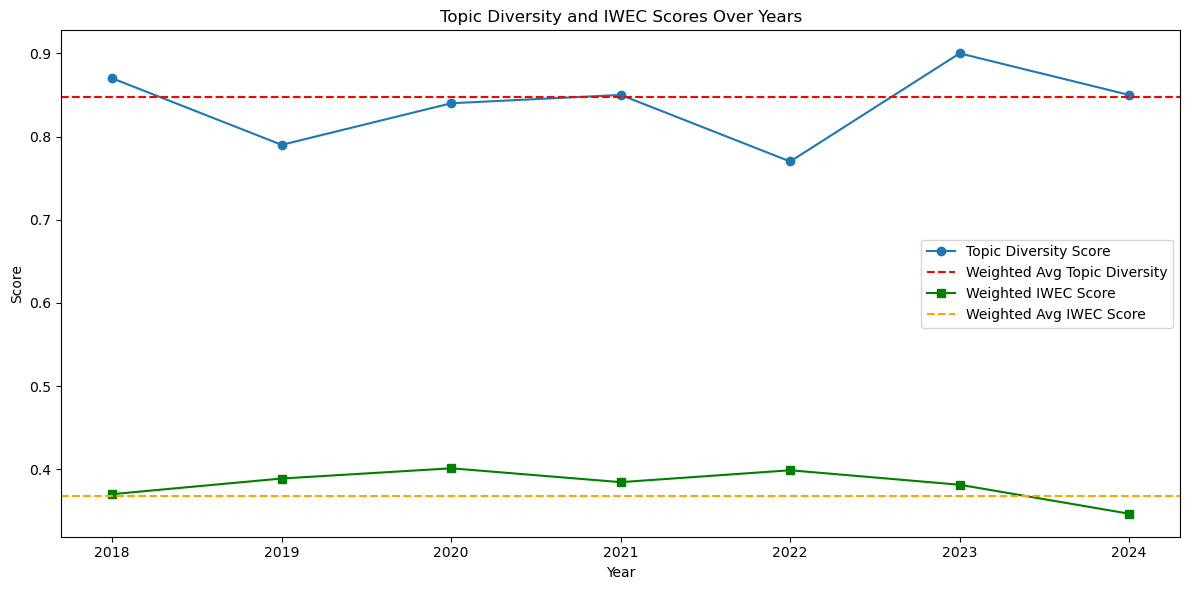

In [13]:
# Plot the results
# Sort the data by year
sorted_indices = np.argsort(years_list)
sorted_years_list = np.array(years_list)[sorted_indices]
sorted_topic_diversity_scores = np.array(topic_diversity_scores)[sorted_indices]
sorted_iwec_scores = np.array([iwec_scores_per_year[year] for year in years_list])[sorted_indices]

plt.figure(figsize=(12, 6))

# Plot Topic Diversity Scores
plt.plot(sorted_years_list, sorted_topic_diversity_scores, marker='o', label='Topic Diversity Score')
plt.axhline(y=avg_weighted_diversity, color='red', linestyle='--', label='Weighted Avg Topic Diversity')

# Plot IWEC Scores
plt.plot(sorted_years_list, sorted_iwec_scores, marker='s', color='green', label='Weighted IWEC Score')
plt.axhline(y=avg_weighted_iwec, color='orange', linestyle='--', label='Weighted Avg IWEC Score')

plt.title('Topic Diversity and IWEC Scores Over Years')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()